<a href="https://colab.research.google.com/github/1bin01/Machine-Learning/blob/main/Introduction-to-Machine-Learning/Ch6_algorithm_chains_and_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mglearn
!pip install --upgrade joblib==1.1.0
!pip install -q --upgrade scikit-learn==1.0.2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn

from importlib import reload  # plt 다시 그릴 때
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 경고 제거 (없어도 문제는 x)

# 나눔 포트 설정 (런타임 다시 시작 해줘야됨!)
import matplotlib as mpl
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic')
mpl.rc('axes', unicode_minus=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, loo

# 알고리즘 체인과 파이프라인

In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 0)
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC().fit(X_train_scaled, y_train)
print("test score : {:.2f}" .format(svm.score(X_test_scaled, y_test)))

test score : 0.97


## 6.1 데이터 전처리와 매개변수 선택

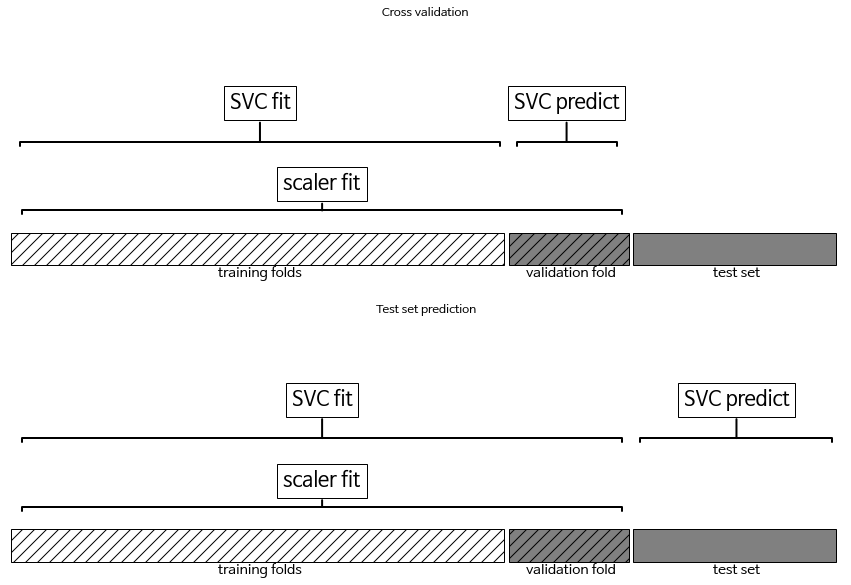

In [3]:
from sklearn.model_selection import GridSearchCV

# 검정 폴드에 사용할 데이터가 train 단계에서 영향을 주는 문제 -> 교차 검증의 분할 단계가 제일 먼저 와야됨
mglearn.plots.plot_improper_processing()

## 6.2 파이프라인 구축하기

In [4]:
# 여러 처리 단계를 하나의 추정기 형태로 묶어줌
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])
pipe.fit(X_train, y_train)
print("test set score : {:.2f}" .format(pipe.score(X_test, y_test)))

test set score : 0.97


## 6.3 그리드 서치에 파이프라인 적용하기

In [5]:
# 매겨변수 그리드 : {단계 이름}__{매개변수 이름}
param_grid = { 'svm__C' : [0.001, 0.01, 0.1, 1, 10, 100], 
              'svm__gamma' : [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)
print("최상의 교차 검증 정확도 : {:.2f}" .format(grid.best_score_))
print("test set score : {:.2f}" .format(grid.score(X_test, y_test)))
print("최적의 매개변수 : ", grid.best_params_)

최상의 교차 검증 정확도 : 0.98
test set score : 0.97
최적의 매개변수 :  {'svm__C': 1, 'svm__gamma': 1}


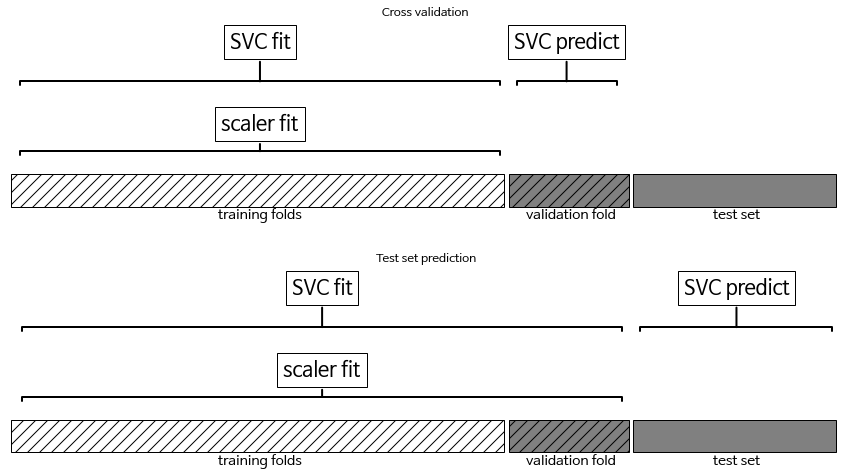

In [6]:
mglearn.plots.plot_proper_processing()

## 6.4 파이프라인 인터페이스

In [8]:
# 6.4.1 make_pipeline을 사용한 파이프라인 생성
from sklearn.pipeline import make_pipeline

pipe_short = make_pipeline(MinMaxScaler(), SVC(C = 100))
print("pipeline 의 단계:\n", pipe_short.steps)

pipeline 의 단계:
 [('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components = 2), StandardScaler())
print("pipe line의 단계 : ", pipe.steps)

pipe line의 단계 :  [('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


In [13]:
# 6.4.2 단계 속성에 접근하기
# named_steps : 단계 이름을 키로 가짐
pipe.fit(cancer.data)
components = pipe.named_steps["pca"].components_
print("components shape : ", components.shape)

components shape :  (2, 30)


In [14]:
# 6.4.3 그리드 서치 안의 파이프라인 속성에 접근하기

from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 1000))
param_grid = {'logisticregression__C' : [0.01, 0.1, 1, 10, 100]}

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 4)
grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(X_train, y_train)

print("best 모델 :\n", grid.best_estimator_)

best 모델 :
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


In [17]:
# 로지스틱 회귀 단계에 접근하기
print("logistic rg 단계 : \n", grid.best_estimator_.named_steps["logisticregression"])
print("logistic rg 계수 : \n", grid.best_estimator_.named_steps["logisticregression"].coef_)

logistic rg 단계 : 
 LogisticRegression(C=1, max_iter=1000)
logistic rg 계수 : 
 [[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


## 6.5 전처리와 모델의 매개변수를 위한 그리드 서치

In [22]:
# pipeline -> 모든 처리 단계를 하나의 추정기로 캡슐화
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state = 0)

pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())
param_grid = {
    'polynomialfeatures__degree' : [1, 2, 3],
    'ridge__alpha' : [0.001, 0.01, 0.1, 1, 10, 100]
}